In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
import pickle
import seaborn as sns
sns.set(style= 'white')

In [5]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

train = pd.read_csv('/content/train.tsv', sep='\t')
test = pd.read_csv('/content/test.tsv', sep='\t')

print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [6]:
train.dtypes

,0
train_id,int64
name,object
item_condition_id,int64
category_name,object
brand_name,object
price,float64
shipping,int64
item_description,object


In [7]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,52.0,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!"
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [8]:
train.price.describe()

,price
count,1.482535e+06
mean,2.673752e+01
std,3.858607e+01
min,0.000000e+00
25%,1.000000e+01
50%,1.700000e+01
75%,2.900000e+01
max,2.009000e+03


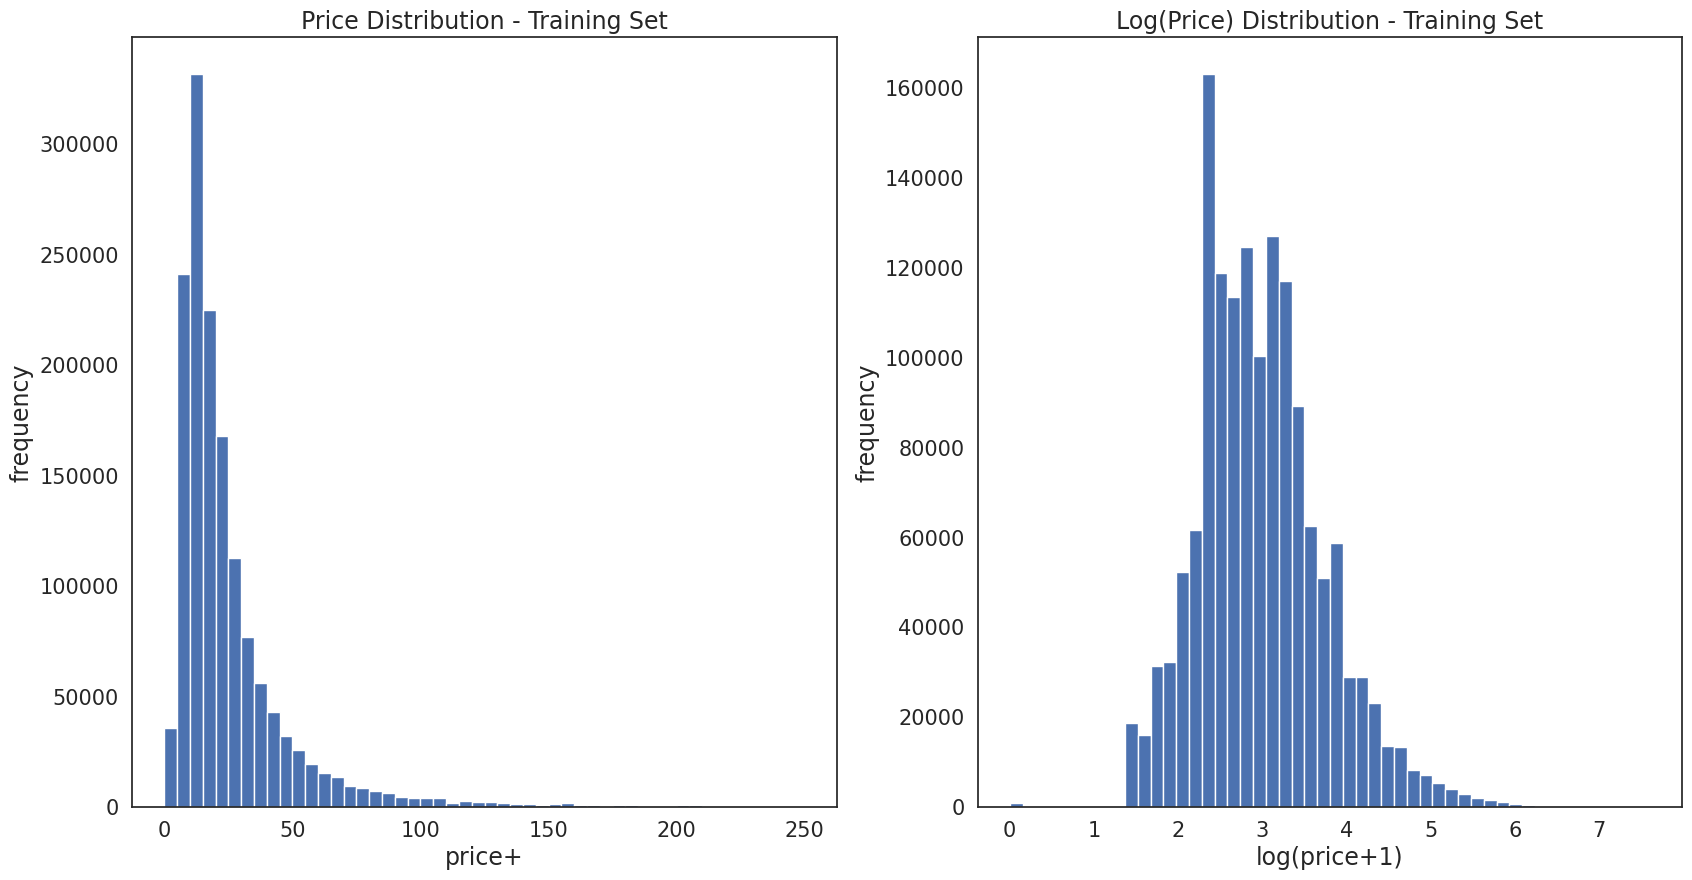

In [9]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20, 10), edgecolor='white', range=[0, 250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price'] + 1).plot.hist(bins=50, figsize=(20, 10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

The effect of shipping to the price of product

In [10]:
print(train.shipping.value_counts() / len(train))

shipping
0    0.552726
1    0.447274
Name: count, dtype: float64


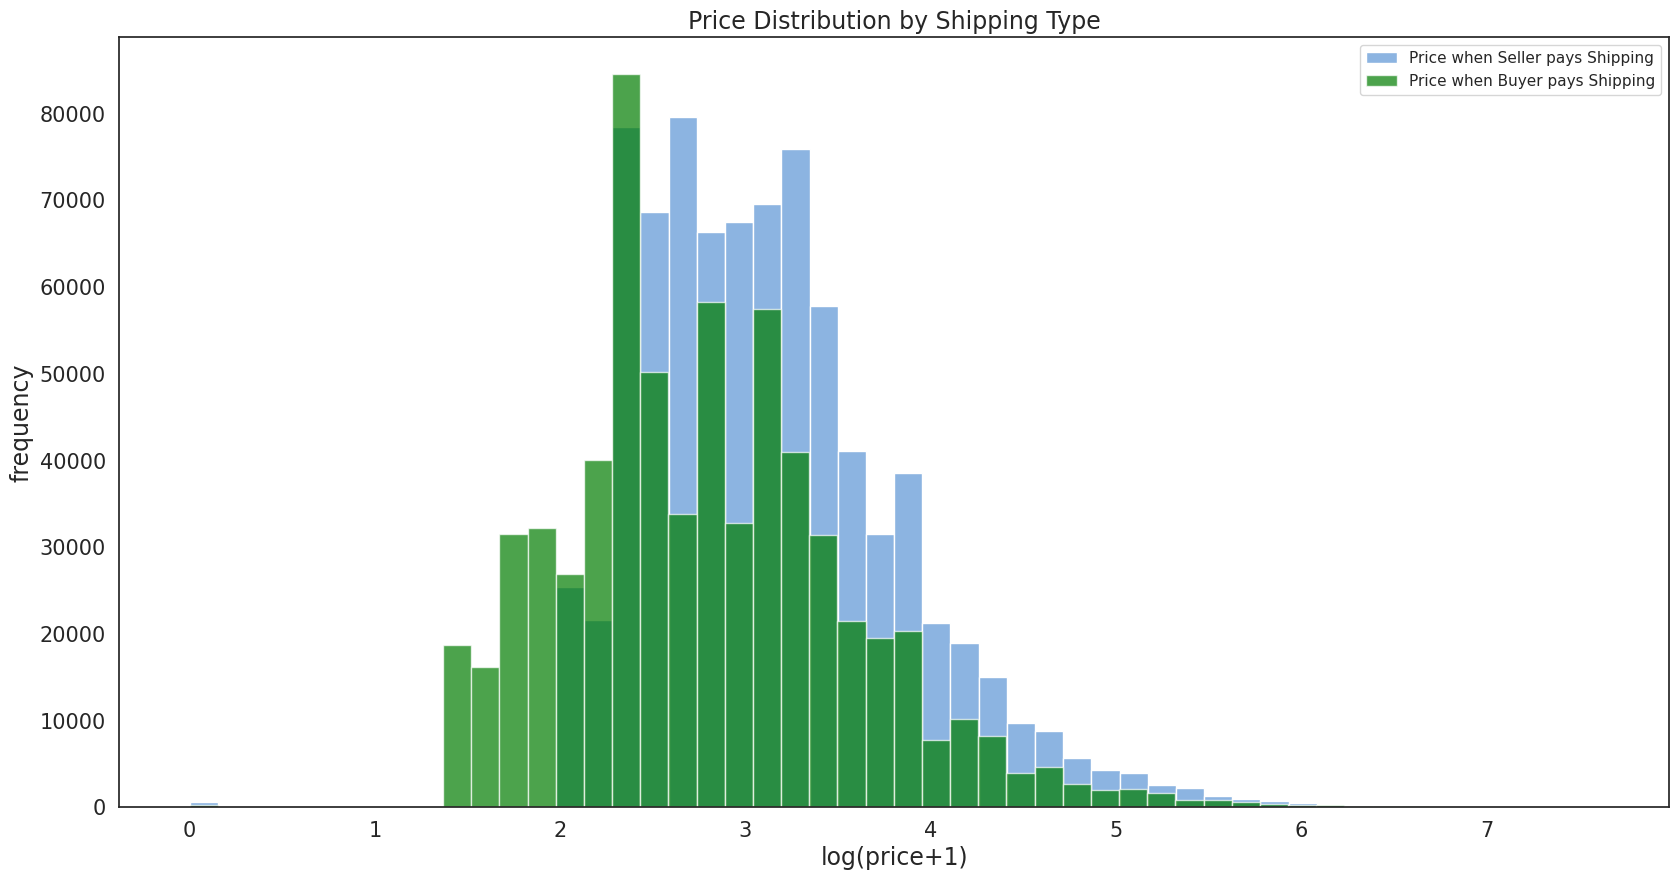

In [11]:
prc_shipBySeller = train.loc[train.shipping == 0, 'price']
prc_shipByBuyer = train.loc[train.shipping == 1, 'price']
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(np.log(prc_shipBySeller + 1), color='#8CB4E1', alpha=1.0, bins=50, label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer + 1), color='#007D00', alpha=0.7, bins=50, label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.legend()
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

Seems like the product price is higher when the seller is paying the shipping

product category

In [12]:
print('There are %d unique values in the category column' % train['category_name'].nunique())
print(train['category_name'].value_counts()[:6])
print('There are %d items that do not have a label' % train['category_name'].isnull().sum())

There are 1287 unique values in the category column
category_name
Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Beauty/Makeup/Eyes                                25215
Name: count, dtype: int64
There are 6327 items that do not have a label


In [13]:
def split_cat(text):
    try:
        return text.split("/")
    except:
        return "No Label", "No Label", "No Label"


train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
print(train.head())
test['general_cat'], test['subcat_1'], test['subcat_2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))
print('There are %d unique general_cat' % train['general_cat'].nunique())
print('There are %d unique first sub-categories' % train['subcat_1'].nunique())
print('There are %d unique second sub-categories' % train['subcat_2'].nunique())

   train_id                                 name  item_condition_id                                       category_name brand_name  price  shipping                                                                                                                                                                              item_description  general_cat             subcat_1            subcat_2
0         0  MLB Cincinnati Reds T Shirt Size XL                  3                                   Men/Tops/T-shirts        NaN   10.0         1                                                                                                                                                                            No description yet          Men                 Tops            T-shirts
1         1     Razer BlackWidow Chroma Keyboard                  3  Electronics/Computers & Tablets/Components & Parts      Razer   52.0         0  This keyboard is in great condition and works like it came out of t

In [15]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [16]:
# analysis the general category
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
pct = [('%.2f' % (v * 100)) + '%' for v in (y / len(train))]
tracel = go.Bar(x=x, y=y, text=pct)
layout = dict(title="Number of Items by Main Category", yaxis=dict(title='Count'), xaxis=dict(title='Category'))
fig = dict(data=[tracel], layout=layout)
py.iplot(fig)

In [19]:
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [20]:
# The Impact of Product Descriptions on Pricing
def wordCount(text):
    try:
        text = text.lower()
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(' ', text)
        words = [w for w in txt.split(" ") if w not in ENGLISH_STOP_WORDS.STOP_WORDS and len(w) > 3]
        return len(words)
    except:
        return 0


train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))
print(train.head())

df = train.groupby('desc_len')['price'].mean().reset_index()
tracel = go.Scatter(x=df['desc_len'], y=np.log(df['price'] + 1), mode='lines+markers', name='lines+markers')
layout = dict(title='Average Log(Price) by Description Length', yaxis=dict(title='Average Log(Price)'),
              xaxis=dict(title='Description Length'))
fig = dict(data=[tracel], layout=layout)
py.iplot(fig)

   train_id                                 name  item_condition_id                                       category_name brand_name  price  shipping                                                                                                                                                                              item_description  general_cat             subcat_1            subcat_2  desc_len
0         0  MLB Cincinnati Reds T Shirt Size XL                  3                                   Men/Tops/T-shirts        NaN   10.0         1                                                                                                                                                                            No description yet          Men                 Tops            T-shirts         0
1         1     Razer BlackWidow Chroma Keyboard                  3  Electronics/Computers & Tablets/Components & Parts      Razer   52.0         0  This keyboard is in great condition and works l

Key word in product describution

In [22]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [24]:
print(train.item_description.isnull().sum())

train = train[pd.notnull(train['item_description'])]

tokenize = nltk.data.load('tokenizers/punkt/english.pickle')
cat_desc = dict()
for cat in train['general_cat'].unique():
    text = ' '.join(train.loc[train['general_cat'] == cat, 'item_description'].values)
    cat_desc[cat] = tokenize.tokenize(text)


flat_lst = [item for sublist in list(cat_desc.values()) for item in sublist]
allWordsCount = Counter(flat_lst)
all_top10 = allWordsCount.most_common(20)
x = [w[0] for w in all_top10]
y = [w[1] for w in all_top10]
tracel = go.Bar(x=x, y=y)
layout = dict(title='Word Frequency', yaxis=dict(title='Count'), xaxis=dict(title='Word'))
fig = dict(data=[tracel], layout=layout)
py.iplot(fig)

0


In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
stop = set(stopwords.words('english'))


def tokenize(text):
    try:
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(' ', text)

        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w) >= 3]
        return filtered_tokens
    except TypeError as e:
        print(text, e)


train['tokens'] = train['item_description'].map(tokenize)
test['tokens'] = test['item_description'].map(tokenize)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
for description, tokens in zip(train['item_description'].head(), train['tokens'].head()):
    print('description:', description)
    print('tokens:', tokens)
    print()

description: No description yet
tokens: ['description', 'yet']

description: This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
tokens: ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app']

description: Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
tokens: ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white']

description: New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
tokens: ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'foot', 'high', 'sold', 'pair', 'questions', 'please', 

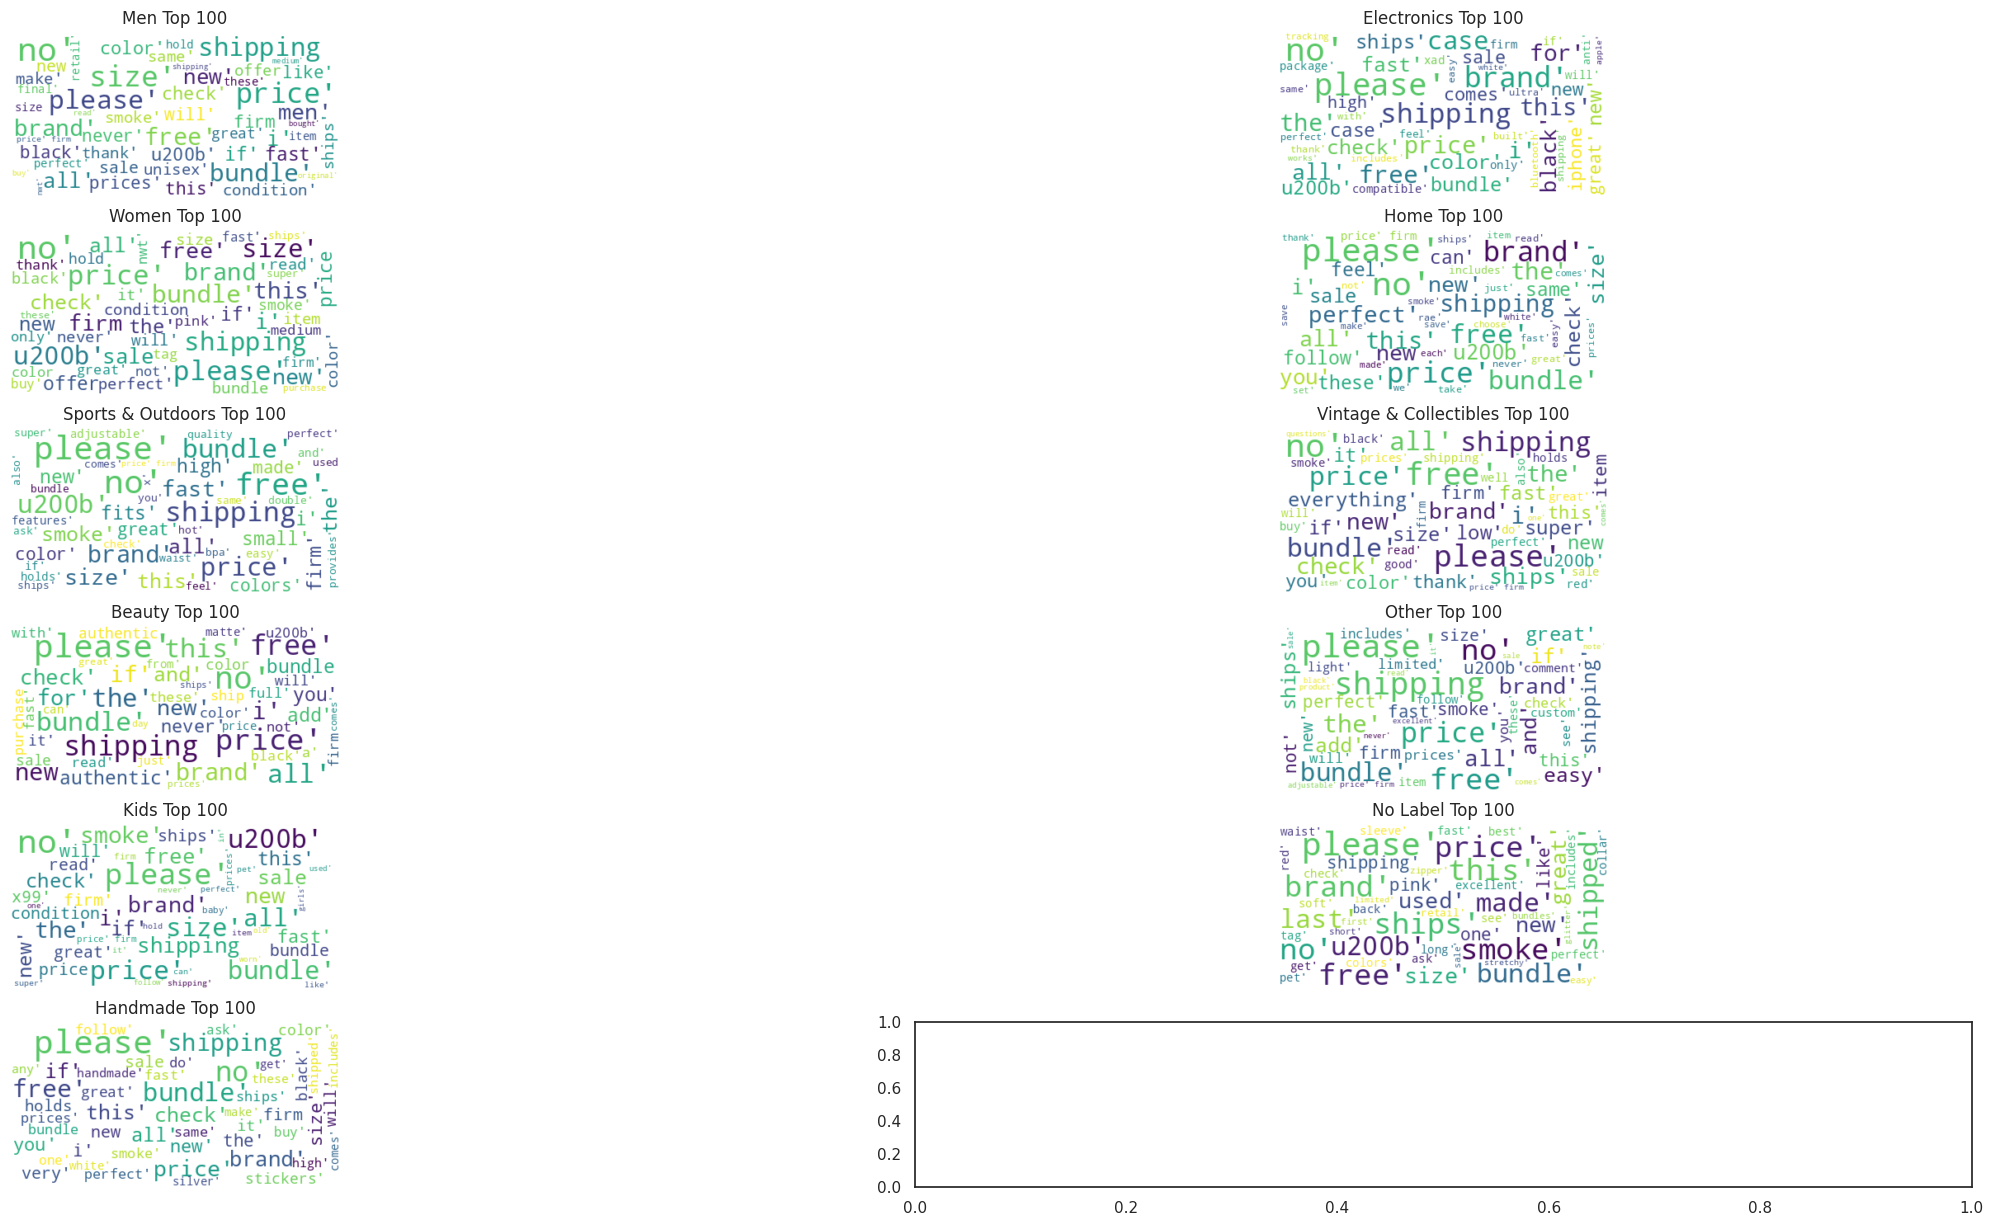

In [28]:
cat_desc = dict()
for cat in train['general_cat'].unique():
    text = ' '.join(train.loc[train['general_cat'] == cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)

cat_desc100 = dict()
for key, value in cat_desc.items():
    cat_desc100[key] = Counter(value).most_common()


def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white', max_words=50, max_font_size=40, random_state=42).generate(str(tup))
    return wordcloud


fig, axes = plt.subplots(len(cat_desc100) // 2 + 1, 2, figsize=(30, 15))

for i, (key, cat) in enumerate(cat_desc100.items()):
    ax = axes[i // 2, i % 2]
    ax.imshow(generate_wordcloud(cat), interpolation='bilinear')
    ax.axis('off')
    ax.set_title("%s Top 100" % key, fontsize=12)

plt.show()

tf-idf

In [29]:
# tf-idf
vectorizer = TfidfVectorizer(min_df=10, max_features=180000, tokenizer=tokenize, ngram_range=(1, 2))
all_desc = np.append(train['item_description'].values, test['item_description'].values)
vz = vectorizer.fit_transform(list(all_desc))
print(vz.shape)

tfidf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']
print(tfidf.sort_values(by=['tfidf'], ascending=True).head(10))
print(tfidf.sort_values(by=['tfidf'], ascending=False).head(10))

(2175888, 180000)
              tfidf
new        2.175652
size       2.330673
brand      2.755659
condition  2.799305
brand new  2.874417
free       2.903425
shipping   3.070591
worn       3.107881
used       3.165309
never      3.276900
                  tfidf
postnatal     13.195053
beats beats   13.195053
subdrip rda   13.195053
lmt           13.195053
♡oval         13.195053
novelty bill  13.195053
lbs length    13.195053
colour brow   13.195053
volts clicks  13.195053
wedgwood      13.195053


In [34]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE


In [35]:
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0
sample_sz = 15000

combined_df = pd.concat([trn, tst])
combined_sample = combined_df.sample(n=sample_sz)
vz_sample = vectorizer.fit_transform(list(combined_sample['item_description']))

n_comp = 30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

plot_tfidf = bp.figure(width=700, height=600, title='tf-idf clustring of the item description',
                       tools='pan, wheel_zoom, box_zoom, reset, hover', x_axis_type=None, y_axis_type=None,
                       min_border=1)
combined_sample.reset_index(inplace=True, drop=True)
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = combined_sample['item_description']
tfidf_df['tokens'] = combined_sample['tokens']
tfidf_df['category'] = combined_sample['general_cat']
plot_tfidf.scatter(x='x', y='y', source=tfidf_df, alpha=0.7)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips = {'description': '@description', 'tokens': '@tokens', 'category': '@category'}
show(plot_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.001s...
[t-SNE] Computed neighbors for 15000 samples in 1.966s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

classification work

In [37]:
from sklearn.cluster import MiniBatchKMeans


In [38]:
# clustering
num_clusters = 10
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, init_size=10000, batch_size=1000,
                               verbose=0, max_iter=1000)
kmeans_model.fit(vz_sample)
kmeans_clusters = kmeans_model.predict(vz_sample)
kmeans_distances = kmeans_model.transform(vz_sample)
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = combined_sample['item_description']
kmeans_df['category'] = combined_sample['general_cat']
plot_kmeans = bp.figure(width=700, height=600, title='KMeans clustering of the description',
                        tools='pan, wheel_zoom, box_zoom, reset, hover', x_axis_type=None, y_axis_type=None,
                        min_border=1)
print(kmeans_clusters)
colormap = {'0': 'red', '1': 'green', '2': 'blue', '3': 'black', '4': 'yellow', '5': 'pink', '6': 'purple', '7': 'grey',
            '8': 'brown', '9': 'orange'}


def get_color(num):
    if num == 0:
        return 'red'
    elif num == 1:
        return 'green'
    elif num == 2:
        return 'blue'
    elif num == 3:
        return 'black'
    elif num == 4:
        return 'yellow'
    elif num == 5:
        return 'pink'
    elif num == 6:
        return 'purple'
    elif num == 7:
        return 'grey'
    elif num == 8:
        return 'brown'
    elif num == 9:
        return 'orange'


color = pd.Series(kmeans_clusters).apply(get_color)
source = ColumnDataSource(
    data=dict(x=kmeans_df['x'], y=kmeans_df['y'], color=color, description=kmeans_df['description'],
              category=kmeans_df['category'], cluster=kmeans_df['cluster']))
plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips = {'description': '@description', 'category': '@category', 'cluster': '@cluster'}
show(plot_kmeans)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.087s...
[t-SNE] Computed neighbors for 15000 samples in 3.522s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

In [39]:
# LDA
cvectorizer = CountVectorizer(min_df=4, max_features=180000, tokenizer=tokenize, ngram_range=(1, 2))
cvz = cvectorizer.fit_transform(combined_sample['item_description'])
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=20, random_state=42)
X_topics = lda_model.fit_transform(cvz)


n_top_words = 10
topic_summaries = []
topic_word = lda_model.components_
vocab = cvectorizer.get_feature_names_out()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}:{}'.format(i, '|'.join(topic_words)))

tsne_lda = tsne_model.fit_transform(X_topics)
unnormalized = np.matrix(X_topics)
doc_topic = unnormalized / unnormalized.sum(axis=1)
lda_keys = []
for i, tweet in enumerate(combined_sample['item_description']):
    lda_keys += [doc_topic[i].argmax()]

lda_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
lda_df['description'] = combined_sample['item_description']
lda_df['category'] = combined_sample['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)
plot_lda = bp.figure(width=700, height=600, title='LDA topic visualization',
                     tools='pan, wheel_zoom, box_zoom, reset, hover', x_axis_type=None, y_axis_type=None, min_border=1)
source = ColumnDataSource(
    data=dict(x=lda_df['x'], y=lda_df['y'], color=color, description=lda_df['description'],
              topic=lda_df['topic'], category=lda_df['category']))
plot_lda.scatter(x='x', y='y', color='color', source=source)
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {'description': '@description', 'topic': '@topic', 'category': '@category'}
show(plot_lda)

Topic 0:iphone|fits|plus|case|color|high|black|light|hair|quality
Topic 1:shipping|free|price|free shipping|firm|bundle|price firm|please|new|items
Topic 2:size|small|medium|worn|black|large|top|fit|dress|size small
Topic 3:new|brand|brand new|never|worn|size|used|never worn|box|never used
Topic 4:gold|included|works|case|easy|months|charger|design|hard|nice
Topic 5:skin|brush|makeup|color|lip|sealed|set|matte|eye|new
Topic 6:pink|cute|secret|victoria|victoria secret|super|excellent condition|excellent|used|super cute
Topic 7:description|yet|description yet|tags|new tags|purple|new|inch|nwot|tried
Topic 8:condition|great|good|like|good condition|great condition|size|used|perfect|wear
Topic 9:free|ship|home|new|smoke|please|ask|bag|free home|smoke free
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.018s...
[t-SNE] Computed neighbors for 15000 samples in 2.025s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional